<hr style="border-top:8px solid black">
<a name='part2'></a>

# Trends, variability and deviation
This notebook is split into three parts:

1. Introduce the ideas behind these trends, variability and deviation.
2. Complete examples of regression for time series without the spatial dimension.
3. Complete example of temporal regression through every pixel in a DataArray.

***

As usual we first need to load our environment.

In [2]:
# Make sure the script is using the proper kernel
try:
    %run ../swiss_utils/assert_env.py
except:
    %run ./swiss_utils/assert_env.py

In [3]:
# Import modules

# reload module before executing code
%load_ext autoreload
%autoreload 2


# define modules locations (you might have to adapt define_mod_locs.py)
%run swiss_utils/define_mod_locs.py

import os
import shutil
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.patches import Polygon, Rectangle

# from swiss_utils.data_cube_utilities.sdc_utilities import load_multi_clean

# import datacube
# dc = datacube.Datacube()

# silence warning (not recommended during development)
import warnings
warnings.filterwarnings("ignore")

# AND THE FUNCTION
# from swiss_utils.data_cube_utilities.sdc_utilities import indices_ts_stats

plt.rcParams['figure.figsize'] = (16,8)       # this line changes the size of the figures displayed in the notebooks

### IMPORTANT: run this cell to load the extra packages for regression!

In [4]:
from scipy.stats import linregress

from matplotlib.dates import date2num, num2date

# two functions to convert back and forth
def xr_date2num(time):
    return date2num(time)

def xr_num2date(time_numeric):
    # transforms the num2date (days since ...) into datetime64 (seconds since ...)
    return np.array([np.datetime64(d) for d in num2date(time_numeric)])

# To check that the two functions work as intended:
# # forward: date to numeric
# xr_date2num(daa.time)
# # backward:
# xr_num2date(xr_date2num(daa.time))

<hr style="border-top:8px solid black" />

## Preparing/downloading our data

We will use a pre-prepared small data subset around Fribourg which we extracted from the Swiss Data Cube for you earlier. <span class="dothis">Download this dataset by running the next cell.</span> After a short while you should see the .nc file appear in the file explorer pane on your left (you may need to click the 'Refresh' button).

<span style="color:gray; font-style:italic">We made this data subset using `ts1_data_preparation.ipynb`. You will find this approach useful when doing your project work.</span>

In [5]:
nc_filename = "ls8_lasrc_swiss_fribourg_example.nc"
import os
if os.path.exists(nc_filename):
    print('File already downloaded.')
else:
    print('Downloading...')
    import requests
    URL = "https://drive.switch.ch/index.php/s/D8mj6rg6VQvlbAw/download"
    response = requests.get(URL)
    open(nc_filename, "wb").write(response.content)
    print('Done.')

File already downloaded.


In [6]:
# Open the prepared Landsat 8 subset for the Fribourg region 
ds = xr.open_dataset('ls8_lasrc_swiss_fribourg_example.nc', engine='netcdf4')

In [7]:
# Create a 'shortcut' variable so that we can work with NDVI directly.
ndvi = ds.ndvi
ndvi

<xarray.DataArray 'ndvi' (time: 313, latitude: 132, longitude: 300)>
[12394800 values with dtype=float64]
Coordinates:
  * time         (time) datetime64[ns] 2013-04-18T10:18:18 ... 2021-11-02T10:...
  * latitude     (latitude) float64 46.81 46.81 46.81 ... 46.77 46.77 46.77
  * longitude    (longitude) float64 7.133 7.133 7.133 ... 7.234 7.234 7.234
    spatial_ref  int32 ...

In [8]:
# To look at the trend through a single point, we'll use these data, resampled to monthly temporal frequency.
ndvi_at_point = ndvi.sel(latitude=slice(46.805 , 46.8),
                        longitude=slice(7.192, 7.193)).mean(('latitude', 'longitude')).resample(time='MS').mean()

<hr style="border-top:8px solid black" />

## Background: how to calculate trends and how to interpret them

In our day-to-day life the words **trend** and **tendency** can often be used interchangeably; in the context of climate, however, they are different. 

> *Climate describes the average weather conditions for a particular location and over a long period of time.
> $[...]$ climate normals—30-year historical averages of variables like temperature and precipitation [...]* (WMO 2022)

The main use: **trend** is a **statistically significant change** over time in our variable. With other words, over a time period in a climatological context (>= 30 years), the values increase or decrease; and there is a very small chance that this is observed by chance. If there is less than **30 years** of data available, one can use the term **tendency** (this is not an agreed-upon term!!!) to highlight that this is not a climatological context.

However, if we **de-trend** our data, it means that any systematic increase in values over time is removed. This independent of whether this change over time is **significant or non-significant**.

***

In order to be statistically significant the following must be fulfilled:
- $p \le \alpha$

The significance level $\alpha$ is chosen by us (usually 5%). In the example of a trend, it is the probability of observing a change over time even though in reality that is not true. *The general definition: it is the probability of rejecting the Null-hypothesis $H_{0}$ (=no trend), given that the Null-hypothesis is true.*
>With other words, we allow to make a mistake in 5% of the cases by assuming there is a trend even though there is no trend. Lowering the value of $\alpha$ makes us more sure there is really a trend, but it also makes it more difficult to find one that is not as obvious.

The $p-value$ (sometimes written only $p$) is the result of a statistical test. In the example of a trend, it is the probability of seeing a change over time as extreme as we do, assuming ($H_{0}$) there is no real trend. *The general definition: it is the probability obtaining a result as extreme, given that $H_{0}$ is true.*

> Example: $H_{0} =$"no trend", $\alpha=0.05$, $p-value=0.0231$ (outcome of our analysis). Because $p \le \alpha$, we reject $H_{0}$ and accept $H_{1}$ the alternative hypothesis that there is a trend. The result is statistically significant at our chosen significance level $\alpha=0.05$. The lower the $p-value$, the less likely that an identified trend was identified even though in reality there is no trend. Reversing the wording: The lower the $p-value$, the more likely there is a real trend.

***
### Doing the calculations


The `linregress()` function takes two arrays of values (x and y) to check if there is a relationship between them. `x` will be time and `y` the NDVI values. If there is a significant relationship between them, it means there is a significant change over time; with other words a statistically significant **trend** or **tendency**.

The output of `linregress` function is multiple statistics. These are: 

#### Slope
The **slope** says how much the change is **per time unit**. If we use monthly data, then the change units will be **change per month**. However, here we are using data with a daily frequency, so the change units will be **change per day**.

#### Intercept
The **intercept** is graphically the point on the y-axis where the regression line cuts through it at **x=0**. This statistic is only of interest for the graphical interpretation in our case.

#### Correlation coefficient (r) and coefficient of determination (r$^{2}$)
The **correlation coefficient** and the **coefficient of determination r$^{2}$** tell us how much of the variance is explained. With other words, how well our regression explains the relationship. 

#### p-value
Statistically, maybe the most important outcome. **Is there really a change over time, or do we see something by chance?**. The lower, the more robust/striking.

If the $r^{2}$ is high, you will always have a **low $p-value$**. But, note that you also have a low r$^{2}$ accompanied by a low $p-value$.
***

### Removing non-valid data points `NaN`
The `linregress` function is very strict with regards to missing data. We can only use data where there are no missing values (`NaN`). The next cell filters them away.

In [9]:
# our values for y and x
y = ndvi_at_point.values  
x = xr_date2num(ndvi_at_point.time.values)

# this checks if the value is a valid numeric data point
clean_mask = np.isfinite(y)  

# the mask has the indices of valid data in y.
# you can compare the before and after:

# y
# y[clean_mask]

# The cleaning is applied to both:
# - time
# - ndvi
# so that they have the same length
y_clean = y[clean_mask]
x_clean = x[clean_mask]

In [10]:
# Finally the regression
result = linregress(x_clean, y_clean)
print(result)

# We are only interested in
# - slope 
# - intercept (only graphical)
# - p-value
# - r-value

LinregressResult(slope=-4.828947187444238e-06, intercept=0.7194657531936325, rvalue=-0.022326193050045937, pvalue=0.835484113098484, stderr=2.3183013480512342e-05, intercept_stderr=0.40184233001850916)


*** 
The output shows us that $p > \alpha$. The change over time is thus not statistically significant.

The information on what the optimal (*ordinary least square regression*) regression looks like is stored in the `result` object. The `slope` and `intercept` can be assessed with `result.slope` and `result.intercept`; slope with `result.slope`, $p-value$ with `result.pvalue`, and $r$ with `result.rvalue`.

The line can be created by plotting the x-values (time) against the values calculated from the simple formula for a line:

$y = m*x + b$,

where $m$ is the slope, $b$ is the intercept, $x$ are the time values (in days), and $y$ are the NDVI values.

Using this information, let's plot the results of the regression:

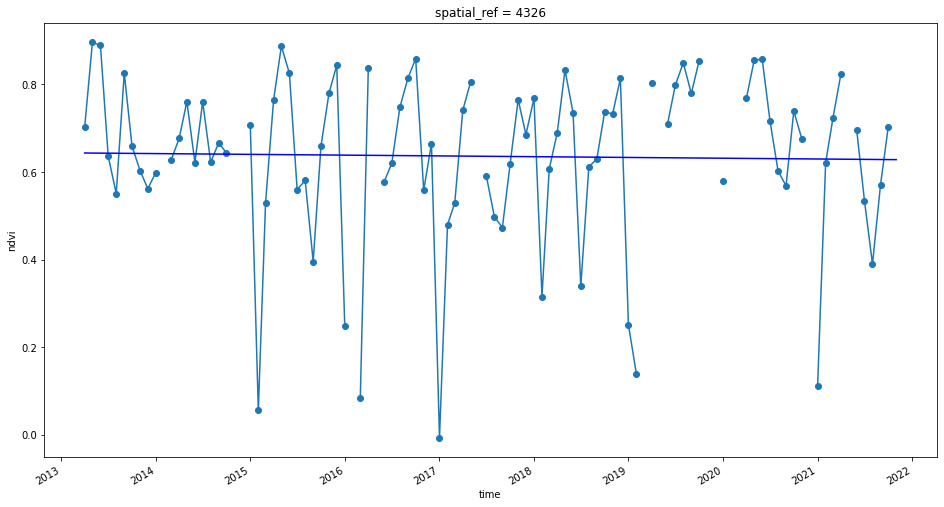

In [11]:
# Plot the underlying data
ndvi_at_point.plot.line(marker='o')

# Plot the regression line
m = result.slope
b = result.intercept
y_pred = m * x + b     # the predicted values; using all time steps (non-filtered)
plt.plot(x, y_pred, 'b-')

### Slope units
As mentioned before, we transform the time. If we look at the `slope` value, we can see a value of `-4.828947187444238e-06`. Since the transformed time values have the units of **days**, this value indicates a change of **-4.828947187444238e-06 per day**.

We can check quickly by looking at the predicted values and corresponding time entries:

In [12]:
print(result.slope)

-4.828947187444238e-06


In [13]:
t0 = x[0]
t1 = x[1]

dt = t1 - t0
print('The difference in days between the two time steps:',dt)

# the predicted NDVI values
ndvi_predicted = m * x + b
ndvi_pred0 = ndvi_predicted[0]
ndvi_pred1 = ndvi_predicted[1]

dndvi = ndvi_pred1 - ndvi_pred0
print('The difference in NDVI from the regression between the two time steps:',dndvi)

rate = dndvi/dt
print('The slope is:',rate)

# Quick check if this rate is the same as from the regression (ratio=1):
print("This should be close to 1:",rate/result.slope)

The difference in days between the two time steps: 30.0
The difference in NDVI from the regression between the two time steps: -0.00014486841562322272
The slope is: -4.828947187440758e-06
This should be close to 1: 0.9999999999992792


<hr style="border-top:8px solid black" />

## Complete examples for time series data

This section shows you how to do regression on DataArrays **with** a `time` dimension but **without** `latitude` and `longitude` dimensions.

In the following you have two examples with a full workflow:
- selecting data
- averaging the data
- resampling to monthly time steps
- filtering NaN values
- running linregress
- plotting

Both examples use the function in the cell below which we have written for you.


In [ ]:
def point_regression(input_data, plot_results=True):
    # regression preparation:
    y = input_data.values  
    x = xr_date2num(input_data.time.values)  

    # only take non-NaN values
    clean_mask = np.isfinite(y)  

    y_clean = y[clean_mask]
    x_clean = x[clean_mask]

    # regression
    reg = linregress(x_clean, y_clean)
    
    if plot_results:

        # slope
        m = reg.slope
        # intercept
        b = reg.intercept

        # calculate regression line (uncleaned data)
        y_pred = reg.slope * x + reg.intercept
        # calculate regression line (cleaned data)
        y_pred_mon = reg.slope * x_clean + reg.intercept

        # plot
        da_mon.plot.line(marker='o', linestyle='-', color='tab:blue')
        plt.plot(x_clean, y_pred_mon, linestyle='-', color='tab:red')
    
    return reg

#### Regression over September data, 2013 to 2021

LinregressResult(slope=-1.5125701869170251e-05, intercept=0.9312656002555586, rvalue=-0.2726706870641748, pvalue=0.47779493454895083, stderr=2.017212402785294e-05, intercept_stderr=0.3517093537928103)

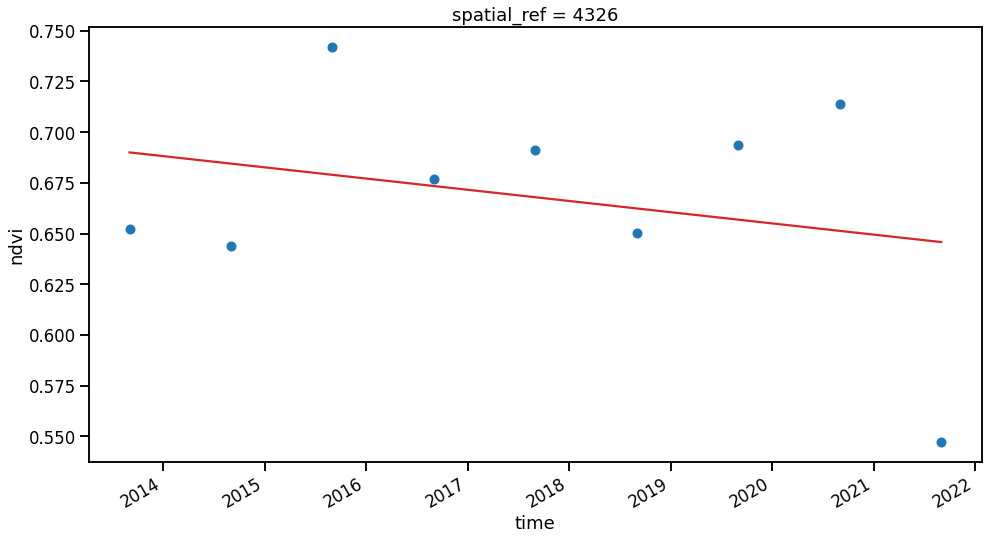

In [55]:
# Prepare our spatial subset
da = ndvi.sel(latitude=slice(46.8, 46.79),  # higher value before lower for latitudes!!
              longitude=slice(7.178, 7.19))
# select all values from September
da_mon = da.sel(time=da.time.dt.month == 9)
# resample to monthly mean at each pixel
da_mon = da_mon.resample(time='MS').mean()
# average over all latitudes and longitudes pixels per time step
da_mon = da_mon.mean(('longitude','latitude'))


# Do the regression. By default this function also produces a plot for you.
reg = point_regression(da_mon)
reg

#### Regression over a single year of data

LinregressResult(slope=0.0006822845099009175, intercept=-10.426948517540957, rvalue=0.7936823394318392, pvalue=0.003542836388822125, stderr=0.00017431650443370107, intercept_stderr=2.827859560699701)

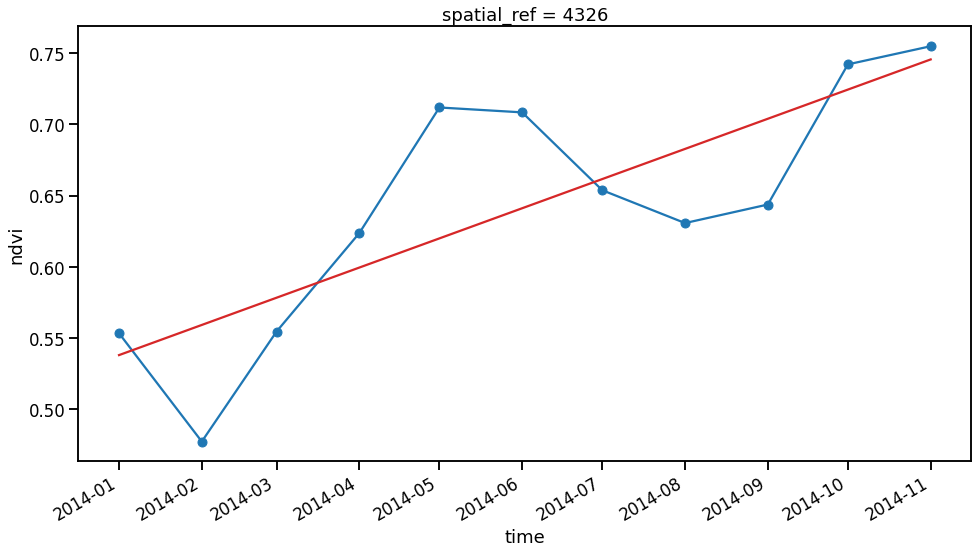

In [54]:
# spatial subset
da = ndvi.sel(latitude=slice(46.8, 46.79),  # higher value before lower for latitudes!!
              longitude=slice(7.178, 7.19))
# Let's look at just a year
da_mon = da.sel(time='2014')
# resample to monthly means
da_mon = da_mon.resample(time='MS').mean()
# average over all latitudes and longitudes per time step
da_mon = da_mon.mean(('longitude','latitude'))
# Do the regression
reg = point_regression(da_mon)
reg

In [57]:
# To just get the regression results without a plot:
reg = point_regression(da_mon, plot_results=False)
reg

LinregressResult(slope=-1.5125701869170251e-05, intercept=0.9312656002555586, rvalue=-0.2726706870641748, pvalue=0.47779493454895083, stderr=2.017212402785294e-05, intercept_stderr=0.3517093537928103)

<hr style="border-top:8px solid black" />

## Complete example for spatio-temporal trends
It is possible to calculate the trend through time for every pixel in our datacube. This allows to compare pixel by pixel in the form of a map.

We've written a function for you that cleans your DataArray and then calculates the trend in every pixel. It's contained in the cell below, you don't need to change anything in this function.



In [30]:
def spatio_temporal_trend(dataset):

    # Don't change anything in the code below.
    x = np.arange(dataset.time.shape[0])

    def new_linregress(y):
        # Wrapper around scipy linregress to use in apply_ufunc
        clean_mask = np.isfinite(y)  
        y_clean = y[clean_mask]
        x_clean = x[clean_mask]
        slope, intercept, r_value, p_value, _ = linregress(x_clean, y_clean)
        return np.array([slope, intercept, r_value, p_value])

    stats = xr.apply_ufunc(new_linregress, dataset, 
                           input_core_dims=[['time']],
                           output_core_dims=[["parameter"]],
                           vectorize=True,
                           dask="parallelized",
                           output_dtypes=['float64'],
                           output_sizes={"parameter": 4},
                          )

    # Give the stats parameters their proper names
    stats['parameter'] = ['slope', 'intercept', 'r_value', 'p_value']
    # Convert to an xarray Dataset
    stats = stats.to_dataset(dim='parameter')
    
    return stats

To use this function, simply supply it with a DataArray with time, latitude and longitude coordinates:

In [31]:
stats = spatio_temporal_trend(ndvi)

This gives us an xarray Dataset with four data variables. We get information on the slope, intercept, r-value and p-value returned:

In [36]:
stats

<xarray.Dataset>
Dimensions:      (latitude: 132, longitude: 300)
Coordinates:
  * latitude     (latitude) float64 46.81 46.81 46.81 ... 46.77 46.77 46.77
  * longitude    (longitude) float64 7.133 7.133 7.133 ... 7.234 7.234 7.234
    spatial_ref  int32 4326
Data variables:
    slope        (latitude, longitude) float64 -9.084e-05 ... -0.0001345
    intercept    (latitude, longitude) float64 0.3896 0.4057 ... 0.6871 0.6817
    r_value      (latitude, longitude) float64 -0.09112 -0.05484 ... -0.05264
    p_value      (latitude, longitude) float64 0.1761 0.4215 ... 0.2917 0.4372

Let's have a look at the r-value:

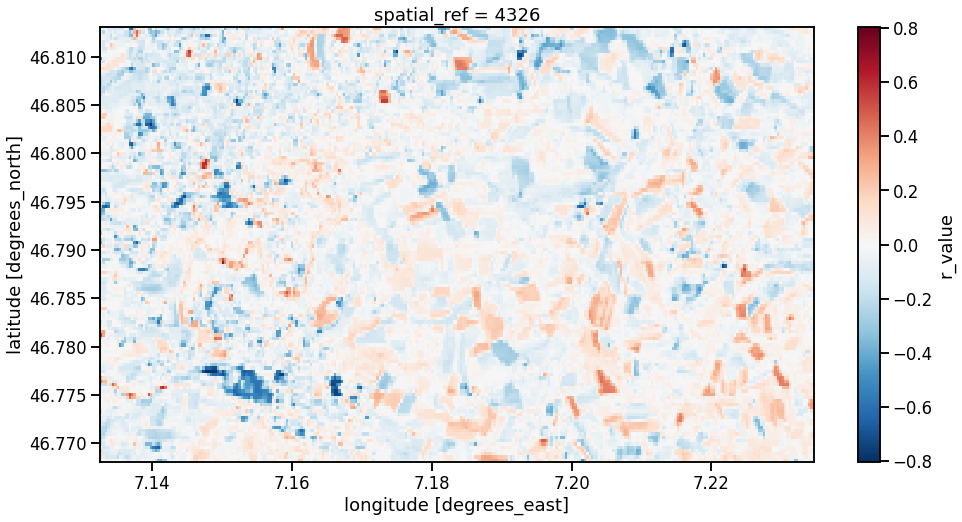

In [37]:
stats.r_value.plot.imshow()

We can also take a look at the p-value:

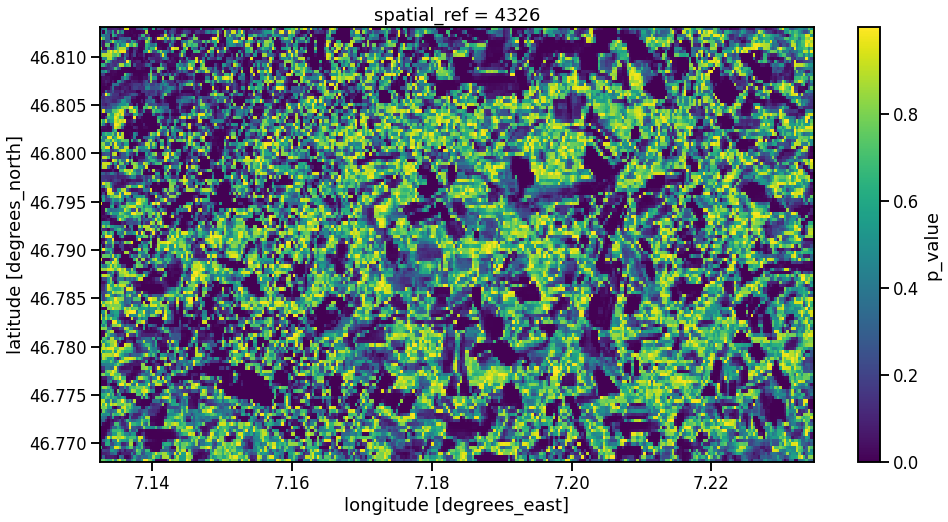

In [38]:
stats.p_value.plot.imshow()

Finally, if we think back to the glacier mapping practical, remember that we can do a few things to help visualise these data:

1) We can set a threshold to show only pixels that meet certain criteria;
2) We can use transparency to overlay two images.

Let's take a look at these now.

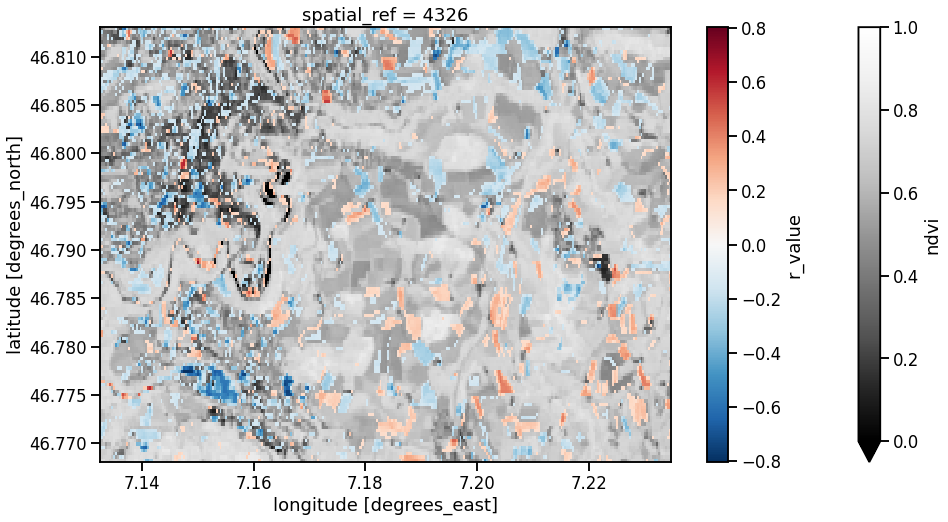

In [47]:
# Draw a map which only shows the r-value at pixels where $p$ is less than 0.05.

# First, we'll put a picture of NDVI in the background.
ndvi.mean(dim='time').plot(cmap='Greys_r', vmin=0, vmax=1)

# On top of this we'll draw only the pixles meeting our p-value criteria of 5% probability.
stats.r_value.where(stats.p_value <= 0.05).plot()